In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [47]:
df = pd.read_csv('train.csv', index_col=0)
print(df.shape)
df.head()

(1460, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [48]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2)

y_train = df_train['SalePrice'].values
y_test = df_test['SalePrice'].values

X_train = df_train.drop('SalePrice', axis=1)
X_test = df_test.drop('SalePrice', axis=1)

cat_features = X_train.dtypes[X_train.dtypes == 'object'].index.values
num_features = X_train.dtypes[X_train.dtypes != 'object'].index.values

In [49]:
X_train[num_features].isnull().sum()[:5]

MSSubClass       0
LotFrontage    200
LotArea          0
OverallQual      0
OverallCond      0
dtype: int64

In [50]:
med = X_train[num_features].median()
X_train = X_train.fillna(med)
X_test = X_test.fillna(med)

In [51]:
from sklearn.metrics import mean_absolute_percentage_error

# наивный прогноз
y_naive_pred = np.median(y_train) * np.ones_like(y_test)
mean_absolute_percentage_error(y_test, y_naive_pred)

0.30670400859565966

In [52]:
from sklearn.neighbors import KNeighborsRegressor

model_knn = KNeighborsRegressor(n_neighbors=10, p=2, weights='distance')
model_knn.fit(X_train[num_features], y_train)
y_pred = model_knn.predict(X_test[num_features])

mean_absolute_percentage_error(y_test, y_pred)

0.15675769254871963

In [53]:
from sklearn.linear_model import LinearRegression

model_reg = LinearRegression()
model_reg.fit(X_train[num_features], y_train)
y_pred = model_reg.predict(X_test[num_features])

mean_absolute_percentage_error(y_test, y_pred)

0.11863087732916804

In [54]:
def show_weights(features, weights, scales):
    fig, axs = plt.subplots(figsize=(14, 10), ncols=2)
    sorted_weights = sorted(zip(weights, features, scales), reverse=True)
    weights = [x[0] for x in sorted_weights]
    features = [x[1] for x in sorted_weights]
    scales = [x[2] for x in sorted_weights]
    sns.barplot(y=features, x=weights, ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=scales, ax=axs[1])
    axs[1].set_xlabel("Scale")
    plt.tight_layout()

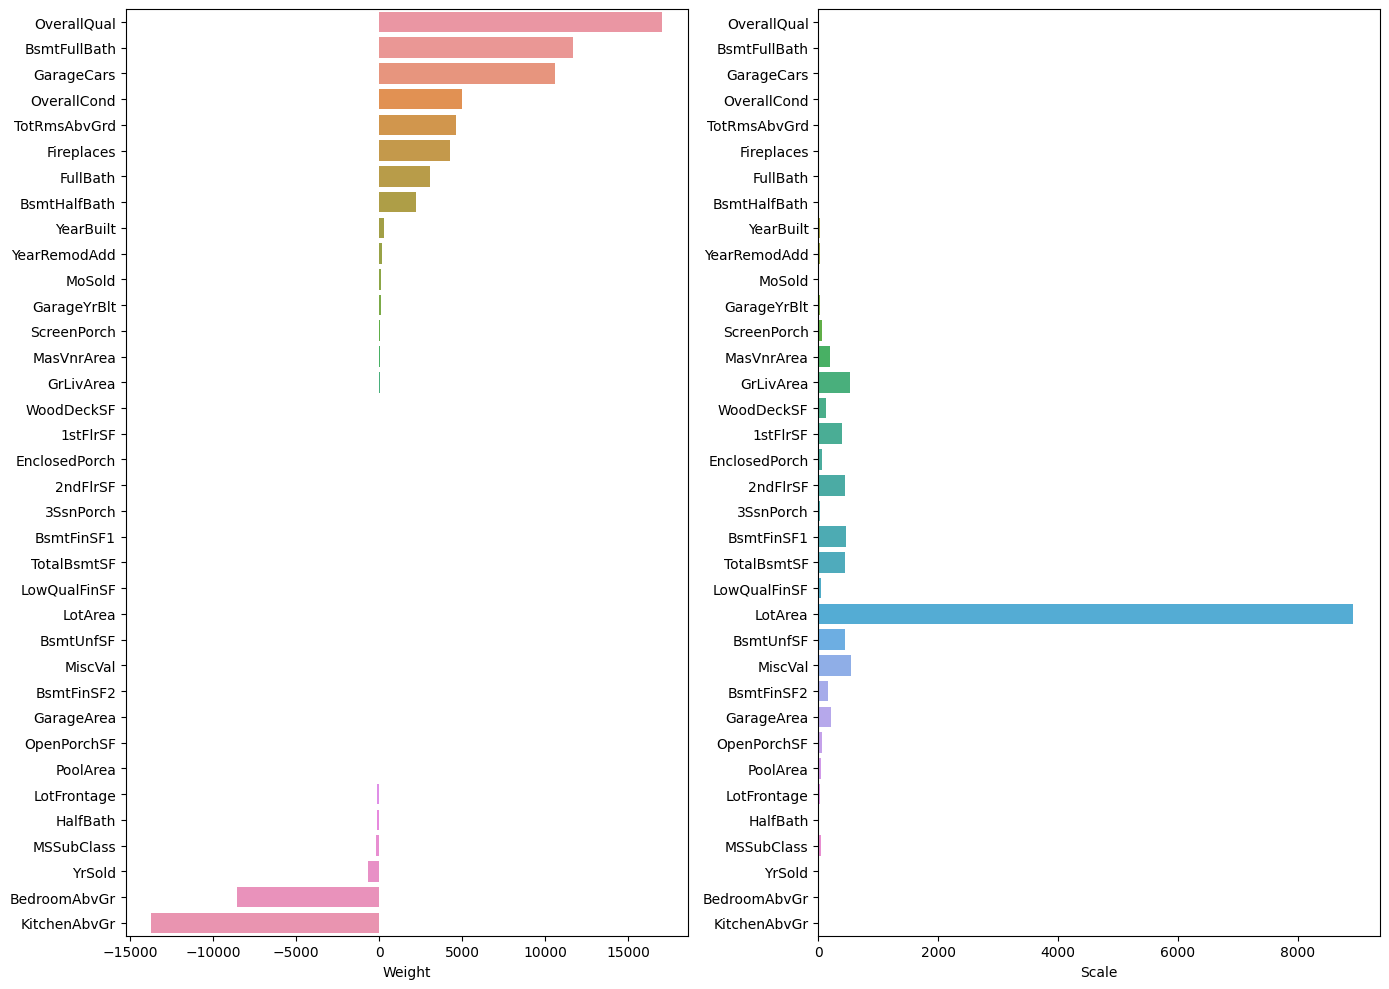

In [55]:
show_weights(num_features, model_reg.coef_, X_train[num_features].std())

In [56]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scale = scaler.fit_transform(X_train[num_features])
X_test_scale = scaler.transform(X_test[num_features])

In [57]:
model_knn = KNeighborsRegressor(n_neighbors=10, p=2, weights='distance')
model_knn.fit(X_train_scale, y_train)
y_pred = model_knn.predict(X_test_scale)

mean_absolute_percentage_error(y_test, y_pred)

0.1132236546369891

In [58]:
model_reg = LinearRegression()
model_reg.fit(X_train_scale, y_train)
y_pred = model_reg.predict(X_test_scale)

mean_absolute_percentage_error(y_test, y_pred)

0.11865773512470577

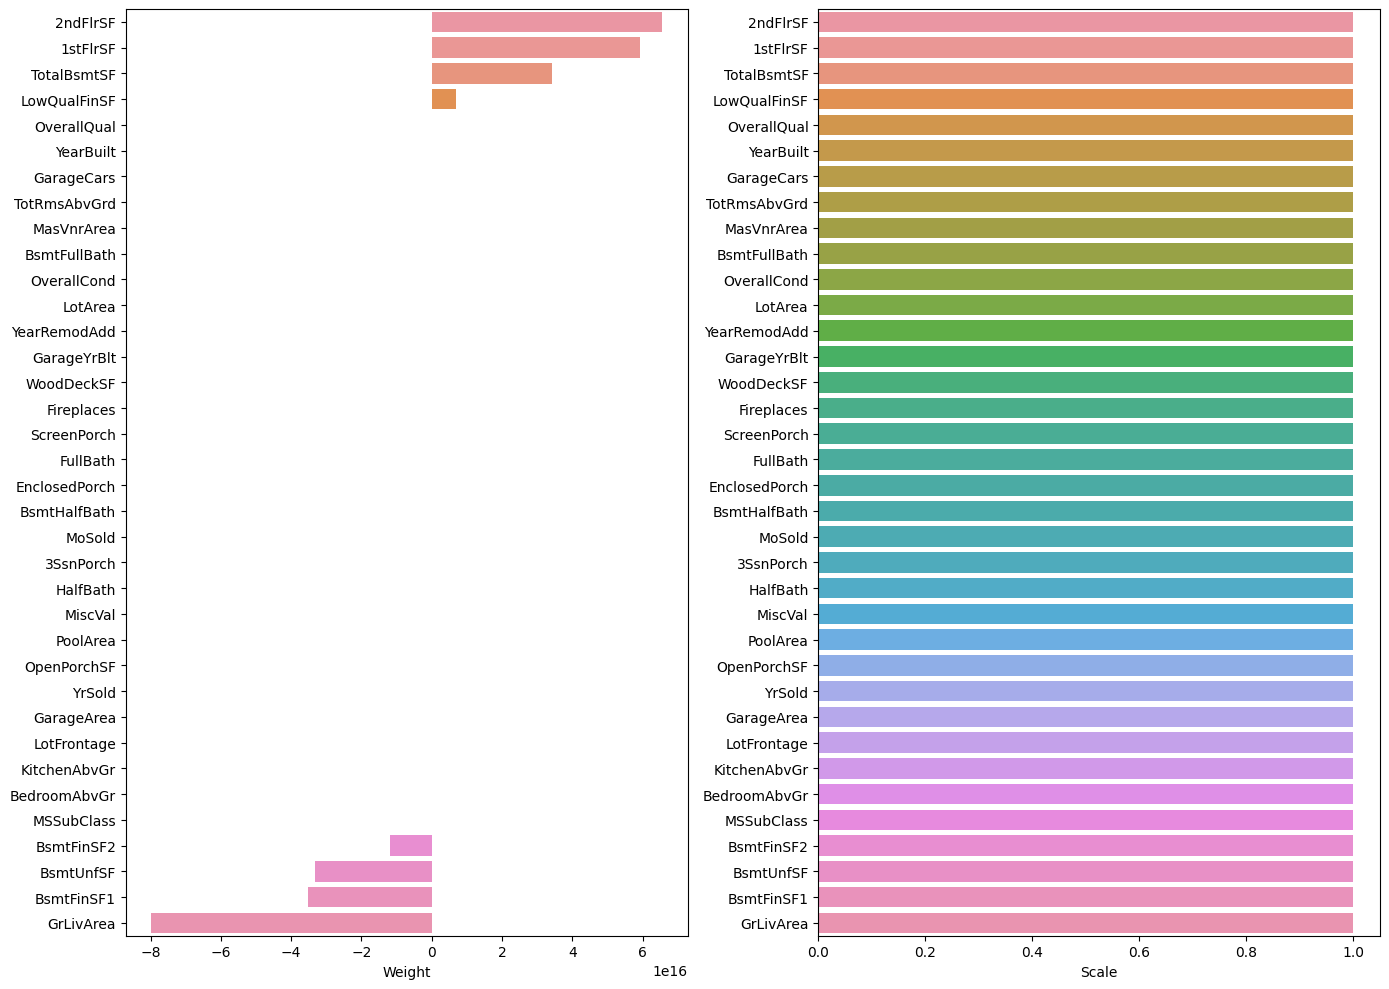

In [59]:
scales = pd.Series(data=X_train_scale.std(axis=0), index=num_features)
show_weights(num_features, model_reg.coef_, scales)

------------

In [125]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso

def get_quality(model, X_train=X_train, X_test=X_test,
               y_train=y_train, y_test=y_test):
    y_pred = model.predict(X_test)
    y_pred_tr = model.predict(X_train)
    print('train mape:', mean_absolute_percentage_error(y_train, y_pred_tr))
    print('test mape:', mean_absolute_percentage_error(y_test, y_pred))


column_transformer = ColumnTransformer([
    ('scaler', StandardScaler(), num_features),
    ('poly', PolynomialFeatures(degree=2, include_bias=False), num_features),
    ('ohe', OneHotEncoder(handle_unknown="ignore", drop='first', 
                          min_frequency=0.001), cat_features)
])

pipeline_knn = Pipeline([
    ('transform', column_transformer),
    ('knn', KNeighborsRegressor())
])

pipeline_rige =  Pipeline([
    ('transform', column_transformer),
    ('ridge', Ridge())
])

pipeline_lasso =  Pipeline([
    ('transform', column_transformer),
    ('lasso', Lasso())
])

In [ ]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)

searcher = GridSearchCV(
    pipeline_rige, [{"ridge__alpha": alphas}],
    scoring="neg_mean_absolute_error", cv=5
)

searcher.fit(X_train, y_train)

In [133]:
searcher.best_params_["ridge__alpha"]

2.3357214690901213

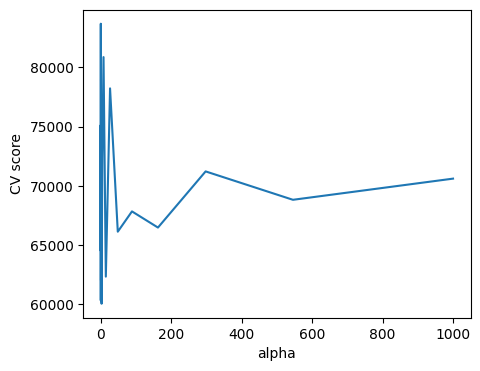

In [135]:
plt.figure(figsize=(5,4))
plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score");

In [127]:
np.abs(pipeline_rige['ridge'].coef_).sum()

72893.5647805425

In [126]:
pipeline_rige.fit(X_train, y_train)
get_quality(pipeline_rige)

train mape: 0.06701977659644026
test mape: 0.2440571448088601


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.88908e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/homebrew/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [10, 14, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [106]:
pipeline_lasso.fit(X_train, y_train)
get_quality(pipeline_lasso)

train mape: 0.009794916219460211
test mape: 0.20304153556895346


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.784e+09, tolerance: 7.414e+08
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [10, 14, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
